In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout, Bidirectional, Multiply, Flatten, Lambda,RepeatVector, Permute 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scipy.stats import zscore
from sklearn.metrics.pairwise import rbf_kernel
from scipy.signal import resample, butter, filtfilt, welch
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

In [2]:
# Constants for sampling rates
PHYSIO_SAMPLING_RATE = 1000  # Hz
VALENCE_SAMPLING_RATE = 20    # Hz
DOWNSAMPLE_FACTOR = PHYSIO_SAMPLING_RATE // VALENCE_SAMPLING_RATE  # 50

In [3]:
def load_data(file_path):
    columns = ["time", "ECG", "BVP", "GSR", "Resp", "Skin_Temp", "EMG_z", "EMG_c", "EMG_t"]
    
    # Read all data first
    df = pd.read_csv(file_path, sep="\t", names=columns)
    
    # Downsample physiological data to match valence-arousal sampling rate
    downsampled_df = df.iloc[::DOWNSAMPLE_FACTOR, :].copy()
    
    # Reset time to new sampling rate
    downsampled_df["time"] = np.arange(len(downsampled_df)) / VALENCE_SAMPLING_RATE
    
    return downsampled_df


In [4]:
# Segment into 5-second windows with proper alignment
def segment_data(physio_df, window_size=5):  # Removed valence_df parameter
    # Calculate number of samples per window
    samples_per_window = window_size * VALENCE_SAMPLING_RATE
    
    # Segment physiological data only
    segments = []
    for i in range(0, len(physio_df), samples_per_window):
        segment = physio_df.iloc[i:i+samples_per_window]
        if len(segment) == samples_per_window:  # only complete segments
            # Calculate time-domain features
            features = {
                "time": segment["time"].mean(),
                "ECG_mean": segment["ECG"].mean(),
                "ECG_std": segment["ECG"].std(),
                "ECG_hr": 60 / (segment["ECG"].diff().abs().mean() + 1e-6),
                "BVP_mean": segment["BVP"].mean(),
                "BVP_std": segment["BVP"].std(),
                "GSR_mean": segment["GSR"].mean(),
                "GSR_std": segment["GSR"].std(),
                "GSR_slope": np.polyfit(np.arange(len(segment)), segment["GSR"], 1)[0],
                "Resp_mean": segment["Resp"].mean(),
                "Resp_std": segment["Resp"].std(),
                "Resp_rate": len(np.where(np.diff(np.sign(segment["Resp"] - segment["Resp"].mean())))[0]) / 2,
                "Skin_temp_mean": segment["Skin_Temp"].mean(),
                "Skin_temp_std": segment["Skin_Temp"].std(),
                "EMG_mean": segment[["EMG_z", "EMG_c", "EMG_t"]].mean().mean(),
                "EMG_std": segment[["EMG_z", "EMG_c", "EMG_t"]].std().mean()
            }
            segments.append(features)
    
    return pd.DataFrame(segments)

In [5]:
def extract_physiological_features(segment):
    """Extract time and frequency domain features from a physiological segment"""
    features = {}
    
    # Time-domain features
    for signal in ['ECG', 'BVP', 'GSR', 'Resp', 'Skin_Temp']:
        sig_data = segment[signal].values
        features.update({
            f"{signal}_mean": np.mean(sig_data),
            f"{signal}_std": np.std(sig_data),
            f"{signal}_max": np.max(sig_data),
            f"{signal}_min": np.min(sig_data),
            f"{signal}_range": np.ptp(sig_data),
            f"{signal}_slope": np.polyfit(np.arange(len(sig_data)), sig_data, 1)[0],
            f"{signal}_diff_mean": np.mean(np.diff(sig_data)),
            f"{signal}_diff_std": np.std(np.diff(sig_data))
        })
    
    # Frequency-domain features (using Welch's method)
    for signal in ['ECG', 'BVP', 'GSR']:
        sig_data = segment[signal].values
        f, Pxx = welch(sig_data, fs=VALENCE_SAMPLING_RATE, nperseg=min(len(sig_data), 256))
        features.update({
            f"{signal}_psd_mean": np.mean(Pxx),
            f"{signal}_psd_std": np.std(Pxx),
            f"{signal}_psd_max": np.max(Pxx),
            f"{signal}_psd_max_freq": f[np.argmax(Pxx)],
            f"{signal}_psd_ratio": np.sum(Pxx[f > 0.1]) / (np.sum(Pxx) + 1e-6)  # ratio of high freq components
        })
    
    # Combined features
    features['HRV'] = np.std(np.diff(np.where(np.diff(segment['ECG']) > 0.5 * np.std(segment['ECG']))[0]))
    features['GSR_peaks'] = len(find_peaks(segment['GSR'], height=np.mean(segment['GSR']))[0])
    
    return features

In [6]:
def compute_rulsif_change_scores(X, alpha=0.1, sigma=1.0, lambda_param=1e-3):
    n = len(X) - 1
    change_scores = np.zeros(n)
    
    for i in range(n):
        X_t, X_t_next = X[i], X[i + 1]
        
        # Compute Gaussian Kernel Matrix
        K_t = rbf_kernel(X_t.reshape(-1, 1), X_t.reshape(-1, 1), gamma=1/(2*sigma**2))
        K_t_next = rbf_kernel(X_t_next.reshape(-1, 1), X_t_next.reshape(-1, 1), gamma=1/(2*sigma**2))
        
        # Compute Weights using Least Squares Importance Fitting (LSIF)
        H = alpha * K_t + (1 - alpha) * K_t_next + lambda_param * np.eye(K_t.shape[0])
        h = np.mean(K_t, axis=1)
        
        theta = np.linalg.solve(H, h)
        
        # Compute Change Score
        change_scores[i] = np.mean(np.square(K_t_next.dot(theta) - 1))
    
    return change_scores

In [7]:
def label_opportune_moments(change_scores):
    mean, std = np.mean(change_scores), np.std(change_scores)
    threshold = mean + 3 * std
    outliers = change_scores > threshold
    
    # Clustering the remaining scores
    valid_indices = np.where(~outliers)[0]  # Indices of non-outliers
    valid_scores = change_scores[valid_indices]
    
    if len(valid_scores) > 1:  # Ensure there are enough samples for clustering
        kmeans = KMeans(n_clusters=2, random_state=42).fit(valid_scores.reshape(-1, 1))
        centroids = kmeans.cluster_centers_.flatten()
        high_cluster = np.argmax(centroids)
        high_values = (kmeans.labels_ == high_cluster) & (valid_scores > centroids[high_cluster])
        
        # Map high_values back to the original indices
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
        high_values_mapped[valid_indices] = high_values
    else:
        high_values_mapped = np.zeros_like(change_scores, dtype=bool)
    
    # Mark opportune moments
    opportune_moments = np.where(outliers | high_values_mapped)[0]
    return opportune_moments

In [8]:
def prepare_input(segmented_data, change_scores):
    # Select only physiological features
    features = [
        'ECG_mean', 'ECG_std', 'ECG_hr', 
        'BVP_mean', 'BVP_std',
        'GSR_mean', 'GSR_std', 'GSR_slope',
        'Resp_mean', 'Resp_std', 'Resp_rate',
        'Skin_temp_mean', 'Skin_temp_std',
        'EMG_mean', 'EMG_std'
    ]
    
    # Add change point scores
    segmented_data['change_score'] = np.concatenate([[0], change_scores])[:len(segmented_data)]
    
    # Prepare input sequence
    input_sequence = segmented_data[features + ['change_score']].values
    
    # Robust scaling
    scaler = RobustScaler()
    input_sequence = scaler.fit_transform(input_sequence)
    
    return input_sequence

In [9]:
def elliott(x, p):
    return (p * x) / (1 + K.abs(x))

# Derivative of PEF
def elliott_derivative(x, p):
    return p / ((K.abs(x) + 1) ** 2)

# Swish Activation Function
def swish(x):
    return x * K.sigmoid(x)

# Custom PEF Activation Layer
class PEFLayer(Activation):
    def __init__(self, activation, **kwargs):
        super(PEFLayer, self).__init__(activation, **kwargs)
        self.p = K.variable(1.0)  # Initialize parameter p

    def call(self, inputs):
        return elliott(inputs, self.p)

# Build p-LSTM Model
def build_p_lstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # p-LSTM Layer with PEF activation
    lstm_out = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))(inputs)
    lstm_out = Dropout(0.5)(lstm_out)  # Dropout for regularization
    lstm_out = PEFLayer(elliott)(lstm_out)
    
    # Fully Connected Layers with PEF activation
    dense1 = Dense(16, kernel_regularizer=l2(0.01))(lstm_out)
    dense1 = Dropout(0.5)(dense1)  # Dropout for regularization
    dense1 = PEFLayer(elliott)(dense1)
    
    # Swish Activation Layer
    swish_out = Activation(swish)(dense1)
    
    # Sigmoid Output Layer for Binary Classification
    outputs = Dense(1, activation="sigmoid")(swish_out)
    
    # Define Model
    model = Model(inputs, outputs)
    return model

In [10]:
import os

def dump_results_to_csv(df_results, method_name, output_dir="evaluation_results"):
    """
    Saves the evaluation results DataFrame to a CSV file.

    Parameters:
        df_results (pd.DataFrame): DataFrame with evaluation results.
        method_name (str): A name for the method to be used in the filename.
        output_dir (str): Directory to save the results. Default is 'evaluation_results/'.
    """
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, f"{method_name}_results.csv")
    df_results.to_csv(file_path, index=False)
    print(f"Saved results to: {file_path}")

In [11]:
def evaluate_fixed_time_method(user_labels):
    results = []

    for user_id, labels in user_labels.items():
        # Predict all 1s for fixed-time baseline
        predictions = np.ones_like(labels)

        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0, 1]).ravel()

        # Compute metrics
        tpr = tp / (tp + fn) if (tp + fn) else 0
        tnr = tn / (tn + fp) if (tn + fp) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        f1 = f1_score(labels, predictions, average='weighted')

        results.append({
            "User": user_id,
            "TPR": tpr,
            "TNR": tnr,
            "FPR": fpr,
            "Weighted F1": f1
        })

    # Create DataFrame and average row
    df_results = pd.DataFrame(results)
    avg_row = {
        "User": "Average",
        "TPR": df_results["TPR"].mean(),
        "TNR": df_results["TNR"].mean(),
        "FPR": df_results["FPR"].mean(),
        "Weighted F1": df_results["Weighted F1"].mean()
    }
    df_results = pd.concat([df_results, pd.DataFrame([avg_row])], ignore_index=True)

    # Round for display
    df_results_rounded = df_results.copy()
    df_results_rounded[["TPR", "TNR", "FPR", "Weighted F1"]] = df_results_rounded[
        ["TPR", "TNR", "FPR", "Weighted F1"]
    ].round(4)

    # Display the results
    print("\n=== Fixed Time Method Evaluation ===\n")
    print(df_results_rounded.to_string(index=False))

    return df_results_rounded


In [12]:
def random_baseline_avg_over_trials(user_inputs, user_labels, seed=42, trials=20):
    np.random.seed(seed)
    all_user_metrics = {}

    for user, inputs in user_inputs.items():
        labels = user_labels[user]
        n_samples = len(labels)

        metrics_per_trial = []

        for _ in range(trials):
            # Fully random 0 or 1 predictions (independent for each sample)
            pred = np.random.choice([0, 1], size=n_samples)

            tn, fp, fn, tp = confusion_matrix(labels, pred, labels=[0, 1]).ravel()

            TPR = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            TNR = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            FPR = fp / (fp + tn) if (fp + tn) > 0 else 0.0
            wF1 = f1_score(labels, pred, average='weighted')

            metrics_per_trial.append((TPR, TNR, FPR, wF1))

        # Compute average across all trials
        metrics_array = np.array(metrics_per_trial)
        avg_tpr, avg_tnr, avg_fpr, avg_wf1 = metrics_array.mean(axis=0)

        all_user_metrics[user] = {
            "User": user,
            "TPR": avg_tpr,
            "TNR": avg_tnr,
            "FPR": avg_fpr,
            "Weighted F1": avg_wf1
        }

    df_results = pd.DataFrame(list(all_user_metrics.values()))

    # Add average row
    avg_row = {
        "User": "Average",
        "TPR": df_results["TPR"].mean(),
        "TNR": df_results["TNR"].mean(),
        "FPR": df_results["FPR"].mean(),
        "Weighted F1": df_results["Weighted F1"].mean()
    }
    df_results = pd.concat([df_results, pd.DataFrame([avg_row])], ignore_index=True)

    # Round for display
    df_results_rounded = df_results.copy()
    df_results_rounded[["TPR", "TNR", "FPR", "Weighted F1"]] = df_results_rounded[
        ["TPR", "TNR", "FPR", "Weighted F1"]
    ].round(4)

    # Display the results
    print("\n=== Fully Random Baseline (Averaged Over Trials) ===\n")
    print(df_results_rounded.to_string(index=False))

    return df_results_rounded


In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [14]:
def evaluate_classical_models(user_inputs, user_labels, df_profiles):
    results_rf = []
    results_xgb = []
    results_svc = []

    for user, input_sequence in user_inputs.items():
        cluster = df_profiles[df_profiles["User"] == user]["Cluster"].values[0]
        similar_users = [u for u in df_profiles[df_profiles["Cluster"] == cluster]["User"] if u != user]

        train_data = []
        train_labels = []
        for u in similar_users:
            if u in user_inputs:
                train_data.append(user_inputs[u])
                train_labels.append(user_labels[u])

        if not train_data:
            print(f"No training data available for {user}. Skipping...")
            continue

        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)

        test_data = input_sequence
        test_labels = user_labels[user]

        models = {
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
            "SVM": SVC(probability=True, random_state=42)
        }

        for model_name, model in models.items():
            model.fit(train_data, train_labels)
            y_pred = model.predict(test_data)
            y_pred_prob = model.predict_proba(test_data)[:, 1]

            tn, fp, fn, tp = confusion_matrix(test_labels, y_pred, labels=[0, 1]).ravel()
            tpr = tp / (tp + fn) if (tp + fn) else 0
            tnr = tn / (tn + fp) if (tn + fp) else 0
            fpr = fp / (fp + tn) if (fp + tn) else 0
            f1 = f1_score(test_labels, y_pred, average='weighted')
            auc = roc_auc_score(test_labels, y_pred_prob)
            acc = accuracy_score(test_labels, y_pred)

            row = {
                "User": user,
                "TPR": tpr,
                "TNR": tnr,
                "FPR": fpr,
                "Weighted F1": f1,
                "AUC": auc,
                "Accuracy": acc
            }

            if model_name == "Random Forest":
                results_rf.append(row)
            elif model_name == "XGBoost":
                results_xgb.append(row)
            elif model_name == "SVM":
                results_svc.append(row)

    # Convert lists to DataFrames
    df_rf = pd.DataFrame(results_rf)
    df_xgb = pd.DataFrame(results_xgb)
    df_svc = pd.DataFrame(results_svc)

    # Add average row to each DataFrame
    for df in [df_rf, df_xgb, df_svc]:
        avg_row = {
            "User": "Average",
            "TPR": df["TPR"].mean(),
            "TNR": df["TNR"].mean(),
            "FPR": df["FPR"].mean(),
            "Weighted F1": df["Weighted F1"].mean(),
            "AUC": df["AUC"].mean(),
            "Accuracy": df["Accuracy"].mean()
        }
        df.loc[len(df)] = avg_row

    # Round metrics for readability
    for df in [df_rf, df_xgb, df_svc]:
        df.iloc[:, 1:] = df.iloc[:, 1:].round(4)

    # Determine best model by average Weighted F1
    avg_f1_scores = {
        "Random Forest": df_rf.loc[df_rf["User"] == "Average", "Weighted F1"].values[0],
        "XGBoost": df_xgb.loc[df_xgb["User"] == "Average", "Weighted F1"].values[0],
        "SVM": df_svc.loc[df_svc["User"] == "Average", "Weighted F1"].values[0]
    }
    best_model = max(avg_f1_scores, key=avg_f1_scores.get)

    return df_rf, df_xgb, df_svc, best_model, avg_f1_scores[best_model]


In [15]:
def evaluate_personalized_plstm(user_inputs, user_labels):
    results = []

    for user, input_sequence in user_inputs.items():
        labels = user_labels[user]

        try:
            X_train, X_test, y_train, y_test = train_test_split(
                input_sequence, labels, test_size=0.2, random_state=42, stratify=labels
            )
        except ValueError:
            print(f"Skipping {user} due to insufficient class distribution.")
            continue

        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = build_p_lstm((X_train.shape[1], X_train.shape[2]))
        model.compile(optimizer=Adam(0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = dict(enumerate(class_weights))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=0
        )

        y_pred_prob = model.predict(X_test).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

        try:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
        except ValueError:
            tn = fp = fn = tp = 0

        tpr = tp / (tp + fn) if (tp + fn) else 0
        tnr = tn / (tn + fp) if (tn + fp) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_pred_prob)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "User": user,
            "TPR": tpr,
            "TNR": tnr,
            "FPR": fpr,
            "Weighted F1": f1,
            "AUC": auc,
            "Accuracy": acc
        })

    df_results = pd.DataFrame(results)
    avg_row = {
        "User": "Average",
        "TPR": df_results["TPR"].mean(),
        "TNR": df_results["TNR"].mean(),
        "FPR": df_results["FPR"].mean(),
        "Weighted F1": df_results["Weighted F1"].mean(),
        "AUC": df_results["AUC"].mean(),
        "Accuracy": df_results["Accuracy"].mean()
    }
    df_results.loc[len(df_results)] = avg_row
    df_results.iloc[:, 1:] = df_results.iloc[:, 1:].round(4)

    print("\n=== Personalized p-LSTM Evaluation ===\n")
    print(df_results.to_string(index=False))

    return df_results

In [16]:
def evaluate_aggregate_p_lstm(user_inputs, user_labels):
    results = []

    for user, test_data in user_inputs.items():
        test_labels = user_labels[user]

        # Use data from all other users for training
        train_data = []
        train_labels = []
        for other_user, other_data in user_inputs.items():
            if other_user != user:
                train_data.append(other_data)
                train_labels.append(user_labels[other_user])

        if not train_data:
            print(f"No training data available for {user}. Skipping...")
            continue

        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)

        print(f"\nTraining aggregate model for user {user} using data from all other users")
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        print(f"Train dist: {np.bincount(train_labels.astype(int))}, Test dist: {np.bincount(test_labels.astype(int))}")

        # Reshape for LSTM [samples, timesteps, features]
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))

        # Build and compile model
        model = build_p_lstm((train_data.shape[1], train_data.shape[2]))
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=BinaryCrossentropy(),
            metrics=["accuracy"]
        )

        # Compute class weights
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        model.fit(
            train_data, train_labels,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=0
        )

        # Evaluate
        y_pred_prob = model.predict(test_data).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(test_labels, y_pred, labels=[0, 1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) else 0
        tnr = tn / (tn + fp) if (tn + fp) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        f1 = f1_score(test_labels, y_pred, average='weighted')
        auc = roc_auc_score(test_labels, y_pred_prob)
        acc = accuracy_score(test_labels, y_pred)

        results.append({
            "User": user,
            "TPR": tpr,
            "TNR": tnr,
            "FPR": fpr,
            "Accuracy": acc,
            "Weighted F1": f1,
            "AUC": auc
        })

    # Create dataframe
    df_results = pd.DataFrame(results)

    # Add average row
    avg_row = {
        "User": "Average",
        "TPR": df_results["TPR"].mean(),
        "TNR": df_results["TNR"].mean(),
        "FPR": df_results["FPR"].mean(),
        "Accuracy": df_results["Accuracy"].mean(),
        "Weighted F1": df_results["Weighted F1"].mean(),
        "AUC": df_results["AUC"].mean()
    }
    df_results.loc[len(df_results)] = avg_row

    # Round for readability
    df_results.iloc[:, 1:] = df_results.iloc[:, 1:].round(4)

    print("\n=== Aggregate p-LSTM Evaluation ===\n")
    print(df_results.to_string(index=False))

    return df_results


In [17]:
def evaluate_gender_based_plstm(user_inputs, user_labels, df_profiles):
    results = []

    for user, input_sequence in user_inputs.items():
        # Get current user's gender
        gender = df_profiles[df_profiles["User"] == user]["Gender"].values[0]

        # Get other users with same gender (excluding current user)
        same_gender_users = df_profiles[(df_profiles["Gender"] == gender) & (df_profiles["User"] != user)]["User"].tolist()
        print(f"User{user} trained on {same_gender_users}")

        train_data, train_labels = [], []
        for u in same_gender_users:
            if u in user_inputs:
                train_data.append(user_inputs[u])
                train_labels.append(user_labels[u])

        if not train_data:
            print(f"Skipping {user} — No same-gender training data available.")
            continue

        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)

        test_data = input_sequence
        test_labels = user_labels[user]

        print(f"\nTraining {user} using gender-based users: {same_gender_users}")
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        print(f"Class distribution — Train: {np.bincount(train_labels.astype(int))}, Test: {np.bincount(test_labels.astype(int))}")

        # Reshape for LSTM: [samples, timesteps, features]
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))

        model = build_p_lstm((train_data.shape[1], train_data.shape[2]))
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss=BinaryCrossentropy(),
                      metrics=["accuracy"])

        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            train_data, train_labels,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=0
        )

        # Evaluation
        y_pred = model.predict(test_data).flatten()
        y_pred_classes = (y_pred > 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_classes, labels=[0, 1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) else 0
        tnr = tn / (tn + fp) if (tn + fp) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        f1 = f1_score(test_labels, y_pred_classes, average='weighted')
        auc = roc_auc_score(test_labels, y_pred)
        acc = accuracy_score(test_labels, y_pred_classes)

        results.append({
            "User": user,
            "TPR": tpr,
            "TNR": tnr,
            "FPR": fpr,
            "Weighted F1": f1,
            "AUC": auc,
            "Accuracy": acc
        })

    df_result = pd.DataFrame(results)

    # Add average row
    avg_row = {
        "User": "Average",
        "TPR": df_result["TPR"].mean(),
        "TNR": df_result["TNR"].mean(),
        "FPR": df_result["FPR"].mean(),
        "Weighted F1": df_result["Weighted F1"].mean(),
        "AUC": df_result["AUC"].mean(),
        "Accuracy": df_result["Accuracy"].mean()
    }
    df_result.loc[len(df_result)] = avg_row
    df_result.iloc[:, 1:] = df_result.iloc[:, 1:].round(4)

    print("\n=== Gender Based p-LSTM Evaluation ===\n")
    print(df_result.to_string(index=False))

    return df_result


In [18]:
def evaluate_age_based_plstm(user_inputs, user_labels, df_profiles):
    results = []

    for user, input_sequence in user_inputs.items():
        # Get current user's age bin
        age_bin = df_profiles[df_profiles["User"] == user]["AgeBin"].values[0]

        # Get other users in same age bin (excluding current user)
        same_age_users = df_profiles[(df_profiles["AgeBin"] == age_bin) & (df_profiles["User"] != user)]["User"].tolist()

        train_data, train_labels = [], []
        for u in same_age_users:
            if u in user_inputs:
                train_data.append(user_inputs[u])
                train_labels.append(user_labels[u])

        if not train_data:
            print(f"Skipping {user} — No training data available in same AgeBin.")
            continue

        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)

        test_data = input_sequence
        test_labels = user_labels[user]

        print(f"\nTraining {user} using age-based users: {same_age_users}")
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        print(f"Class distribution — Train: {np.bincount(train_labels.astype(int))}, Test: {np.bincount(test_labels.astype(int))}")

        # Reshape for LSTM: [samples, timesteps, features]
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))

        model = build_p_lstm((train_data.shape[1], train_data.shape[2]))
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss=BinaryCrossentropy(),
                      metrics=["accuracy"])

        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            train_data, train_labels,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=0
        )

        # Evaluation
        y_pred = model.predict(test_data).flatten()
        y_pred_classes = (y_pred > 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_classes, labels=[0, 1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) else 0
        tnr = tn / (tn + fp) if (tn + fp) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        f1 = f1_score(test_labels, y_pred_classes, average='weighted')
        auc = roc_auc_score(test_labels, y_pred)
        acc = accuracy_score(test_labels, y_pred_classes)

        results.append({
            "User": user,
            "TPR": tpr,
            "TNR": tnr,
            "FPR": fpr,
            "Weighted F1": f1,
            "AUC": auc,
            "Accuracy": acc
        })

    df_result = pd.DataFrame(results)

    # Add average row
    avg_row = {
        "User": "Average",
        "TPR": df_result["TPR"].mean(),
        "TNR": df_result["TNR"].mean(),
        "FPR": df_result["FPR"].mean(),
        "Weighted F1": df_result["Weighted F1"].mean(),
        "AUC": df_result["AUC"].mean(),
        "Accuracy": df_result["Accuracy"].mean()
    }
    df_result.loc[len(df_result)] = avg_row
    df_result.iloc[:, 1:] = df_result.iloc[:, 1:].round(4)

    print("\n=== Age Based p-LSTM Evaluation ===\n")
    print(df_result.to_string(index=False))

    return df_result


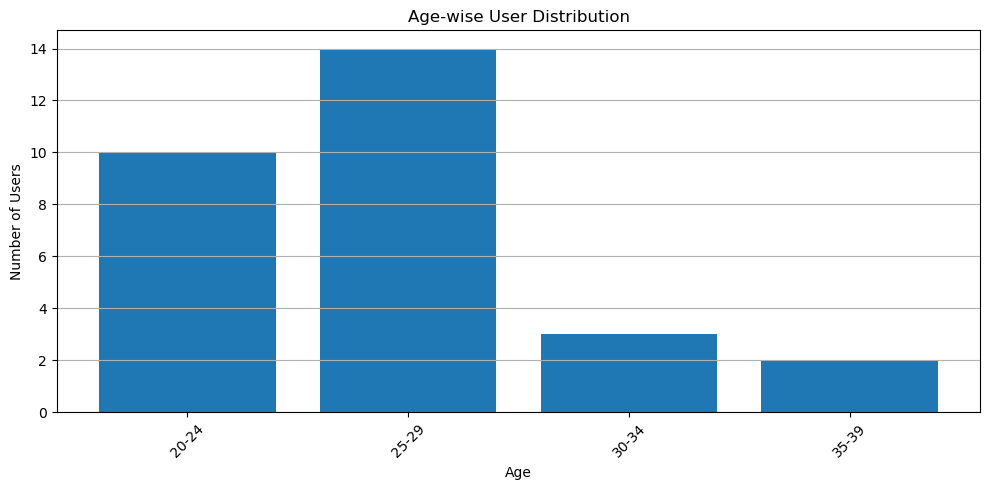

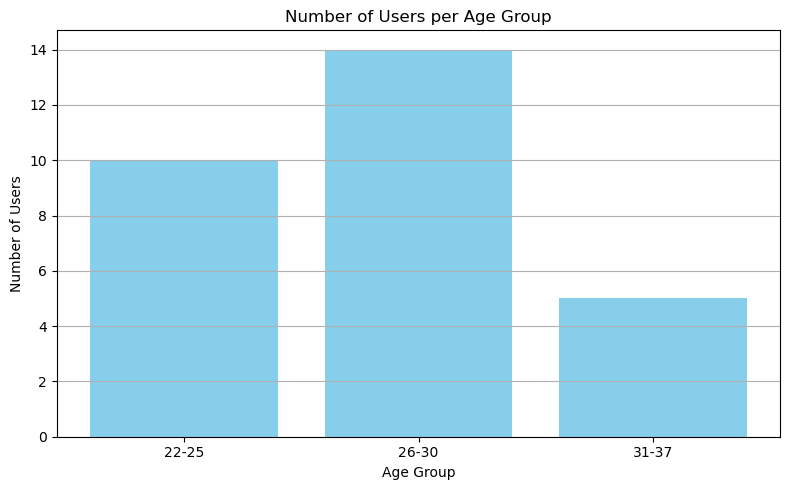

AgeBin
22-25    10
26-30    14
31-37     5
Name: count, dtype: int64

=== Fully Random Baseline (Averaged Over Trials) ===

   User    TPR    TNR    FPR  Weighted F1
  User1 0.4963 0.5029 0.4971       0.5207
  User2 0.5133 0.5023 0.4977       0.5858
  User3 0.4987 0.4939 0.5061       0.5336
  User4 0.4904 0.4947 0.5053       0.5810
  User5 0.5064 0.5123 0.4877       0.5831
  User6 0.5320 0.5047 0.4953       0.5885
  User8 0.5022 0.4893 0.5107       0.5912
  User9 0.5140 0.4945 0.5055       0.5983
 User10 0.4969 0.5073 0.4927       0.5689
 User11 0.4979 0.5002 0.4998       0.5700
 User12 0.5110 0.4950 0.5050       0.5907
 User13 0.5128 0.4975 0.5025       0.5962
 User14 0.4854 0.4903 0.5097       0.5872
 User15 0.4985 0.5095 0.4905       0.5821
 User16 0.4717 0.5031 0.4969       0.5826
 User17 0.5095 0.5037 0.4963       0.5837
 User18 0.4925 0.4951 0.5049       0.6014
 User19 0.5080 0.5026 0.4974       0.6035
 User20 0.4792 0.4933 0.5067       0.5631
 User21 0.4875 0.5099 0.4901       0

In [ ]:
def main():
    
    user_reports = []

    # User profiles with pre-defined clusters
    df_profiles = pd.DataFrame({
        "User": ["User1", "User2", "User3", "User4", "User5", "User6", "User8", "User9", "User10",
                "User11", "User12", "User13", "User14", "User15", "User16", "User17", "User18",
                "User19", "User20", "User21", "User22", "User23", "User24", "User25", "User26",
                "User27", "User28", "User29", "User30"],
        "Cluster": [0, 0, 0, 1, 1, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 0, 0, 0, 0, 0, 1,
                   0, 0, 1, 0]
    })

    df_participant = pd.read_excel("case_dataset-master/case_dataset-master/metadata/participants.xlsx")
    #print(df_participant.columns.tolist())

    df_participant.drop(columns=["Video Sequence Used "], inplace=True)
    df_participant = df_participant[df_participant["Participant-ID"] != 7]
    df_profiles["Participant-ID"] = df_profiles["User"].str.extract(r'(\d+)').astype(int)
    df_profiles = df_profiles.merge(df_participant, on="Participant-ID", how="left")
    df_profiles.rename(columns={"Sex": "Gender", "Age-Group": "AgeGroup"}, inplace=True)
    df_profiles.drop(columns=["Participant-ID"], inplace=True)
   # print(df_profiles)
   # print(df_profiles.columns)
    age_counts = df_profiles["AgeGroup"].value_counts().sort_index()

    # Plot age distribution
    plt.figure(figsize=(10, 5))
    plt.bar(age_counts.index.astype(str), age_counts.values)
    plt.xlabel("Age")
    plt.ylabel("Number of Users")
    plt.title("Age-wise User Distribution")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    def convert_age_range_to_num(age_str):
        if pd.isna(age_str):
            return None
        if '-' in str(age_str):
            low, high = age_str.split('-')
            return (int(low) + int(high)) / 2
        try:
            return float(age_str)
        except:
            return None

    df_profiles["AgeGroup"] = df_profiles["AgeGroup"].apply(convert_age_range_to_num)
    bins = [22, 25, 30, 37]
    labels = ["22-25", "26-30", "31-37"]
    df_profiles["AgeBin"] = pd.cut(df_profiles["AgeGroup"], bins=bins, labels=labels, include_lowest=True)
    age_bin_counts = df_profiles["AgeBin"].value_counts().sort_index()

    plt.figure(figsize=(8,5))
    plt.bar(age_bin_counts.index.astype(str), age_bin_counts.values, color='skyblue')
    plt.xlabel("Age Group")
    plt.ylabel("Number of Users")
    plt.title("Number of Users per Age Group")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Print counts
    print(age_bin_counts)



    # Preprocess data for all users
    user_inputs = {}
    user_labels = {}
    for i in range(1, 31):
        user_id = f"User{i}"
        # Skip User7 which doesn't exist in your list
        if i == 7:
            continue
            
        try:
            physio_file = f"case_dataset-master/case_dataset-master/data/raw/physiological/sub{i}_DAQ.txt"
            
            # Load only physiological data
            df_physio = load_data(physio_file)
            
            # Segment data (now only needs physio data)
            segmented_data = segment_data(df_physio)
            
            # Compute change scores
            physio_features = segmented_data[['ECG_mean', 'BVP_mean', 'GSR_mean', 
                                           'Resp_mean', 'Skin_temp_mean', 'EMG_mean']].values
            change_scores = compute_rulsif_change_scores(physio_features)
            
            # Label opportune moments
            opportune_moments = label_opportune_moments(change_scores)
            labels = np.zeros(len(segmented_data))
            labels[opportune_moments] = 1
            
            # Prepare input sequence (now without valence/arousal)
            input_sequence = prepare_input(segmented_data, change_scores)
            
            # Only keep samples where we have all data
            valid_indices = ~np.isnan(input_sequence).any(axis=1)
            input_sequence = input_sequence[valid_indices]
            labels = labels[valid_indices]
            
            user_inputs[user_id] = input_sequence
            user_labels[user_id] = labels
            
        except FileNotFoundError:
            print(f"Data for {user_id} not found. Skipping...")
            continue
    
    # df_fixed_results = evaluate_fixed_time_method(user_labels)
    # dump_results_to_csv(df_fixed_results, method_name="fixed_time")
    # df_random_results = random_baseline_avg_over_trials(user_inputs, user_labels)
    # dump_results_to_csv(df_random_results, method_name="random_time")
    # df_rf, df_xgb, df_svc, best_model, best_score = evaluate_classical_models(user_inputs, user_labels, df_profiles)
    # dump_results_to_csv(df_rf, method_name="random_forest")
    # dump_results_to_csv(df_xgb, method_name="xgb")
    # dump_results_to_csv(df_svc, method_name="svc")

    # print("=== Random Forest Results ===")
    # print(df_rf.to_string(index=False))

    # print("\n=== XGBoost Results ===")
    # print(df_xgb.to_string(index=False))

    # print("\n=== SVM Results ===")
    # print(df_svc.to_string(index=False))

    # print(f"\nBest model overall: {best_model} with Average Weighted F1 = {best_score:.4f}")

    # df_result = evaluate_personalized_plstm(user_inputs, user_labels)
    # dump_results_to_csv(df_result, method_name="personalized_plstm")
    # df_result = evaluate_aggregate_p_lstm(user_inputs, user_labels)
    # dump_results_to_csv(df_result, method_name="aggregate_plstm")
    # df_result = evaluate_gender_based_plstm(user_inputs, user_labels, df_profiles)
    # dump_results_to_csv(df_result, method_name="gender_based_plstm")
    # df_result = evaluate_age_based_plstm(user_inputs, user_labels, df_profiles)
    # dump_results_to_csv(df_result, method_name="age_based_plstm")

            
    


if __name__ == "__main__":
    main()